## Question 3: Real or Fake Solution 1

Start by checking internet connection and accessing the fastai library

In [2]:
# NB: This code is heavily based on the fast.ai bird classifier example.
#    This code is only here to check that your internet is enabled.

import socket,warnings
try:
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
except socket.error as ex: raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")

In [3]:
# `!pip install -Uqq <libraries>` upgrades to the latest version of <libraries>

import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    !pip install -Uqq fastai

## Step 1: Import the dataset

Get real/fake images from repository. Note that due to the high number of images (10,000), only a portion of the entire training set and testing set could be downloaded.

In [4]:
from fastcore.all import *
from fastai.vision.all import *

path = Path('archive/train')

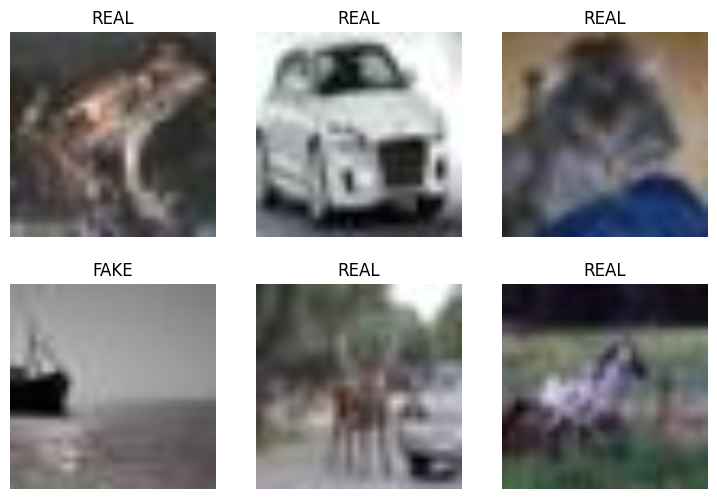

In [11]:
# Create the data loaders and ensure the images are the same size (192x192) by 'squish'. Reserve 20% of the images for testing.
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path)

# Show an example batch of 6 images
dls.show_batch(max_n=6)

Apply fine tuning to resnet18

In [12]:
# Use resnet18 train as a reference and fine tune the model
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

Plot the confusion matrix so far

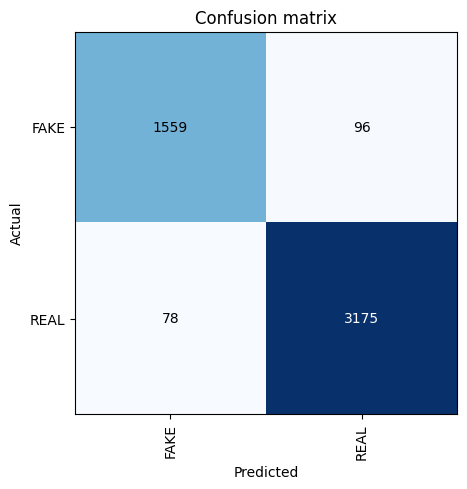

In [13]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

Export the model

In [63]:
learn.export('model_1.pkl')

# Step 2: Testing

Load the exported model

In [5]:
model = load_learner('model_1.pkl')

Create dataloaders for the test set

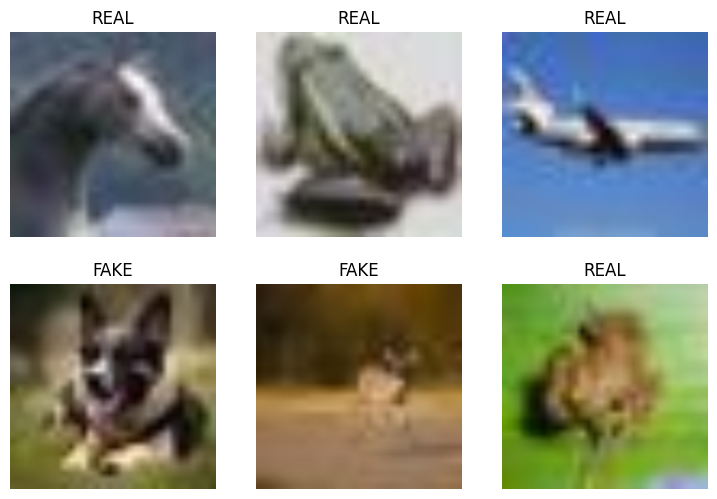

In [7]:
# Create the data loaders and ensure the images are the same size (192x192) by 'squish'. Reserve 10% of the images for validation.
# Set the path to your test set
test_path = Path('archive/test')

test_dataloader = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.1, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(test_path)

# Show an example batch of 6 images
test_dataloader.show_batch(max_n=6)

Evaluate the model

In [8]:
# Set the model to evaluation mode
model.eval()

# Initialize lists for storing predictions and targets
all_predictions = []
all_targets = []

# Iterate over the test dataloader
for batch in test_dataloader.valid:
    inputs, targets = batch

    # Forward pass
    with torch.no_grad():
        outputs = model.forward(inputs)  # Make sure to use the correct forward method

    # Apply softmax to get probabilities
    probabilities = torch.softmax(outputs, dim=1)

    # Get predicted labels
    _, predictions = torch.max(probabilities, dim=1)

    # Append predictions and targets to the lists
    all_predictions.extend(predictions.tolist())
    all_targets.extend(targets.tolist())

# Convert the predictions and targets to tensors
all_predictions = torch.tensor(all_predictions)
all_targets = torch.tensor(all_targets)

# Convert tensor labels to class labels
class_labels = test_dataloader.vocab[all_predictions]

# Print the predicted labels
print(class_labels)

['REAL', 'FAKE', 'REAL', 'REAL', 'REAL', 'REAL', 'REAL', 'FAKE', 'FAKE', 'REAL', 'REAL', 'REAL', 'REAL', 'REAL', 'REAL', 'REAL', 'REAL', 'FAKE', 'FAKE', 'REAL', 'REAL', 'REAL', 'REAL', 'REAL', 'REAL', 'REAL', 'REAL', 'REAL', 'REAL', 'REAL', 'FAKE', 'FAKE', 'REAL', 'REAL', 'FAKE', 'REAL', 'FAKE', 'REAL', 'REAL', 'REAL', 'REAL', 'REAL', 'REAL', 'REAL', 'REAL', 'FAKE', 'REAL', 'REAL', 'REAL', 'FAKE', 'REAL', 'REAL', 'REAL', 'REAL', 'REAL', 'FAKE', 'REAL', 'REAL', 'REAL', 'FAKE', 'FAKE', 'REAL', 'REAL', 'FAKE', 'REAL', 'REAL', 'REAL', 'REAL', 'REAL', 'REAL', 'REAL', 'FAKE', 'REAL', 'REAL', 'REAL', 'REAL', 'FAKE', 'REAL', 'FAKE', 'REAL', 'FAKE', 'REAL', 'REAL', 'REAL', 'REAL', 'REAL', 'REAL', 'REAL', 'REAL', 'REAL', 'REAL', 'REAL', 'REAL', 'REAL', 'REAL', 'REAL', 'FAKE', 'FAKE', 'REAL', 'REAL', 'REAL', 'REAL', 'REAL', 'REAL', 'REAL', 'REAL', 'REAL', 'REAL', 'FAKE', 'REAL', 'REAL', 'REAL', 'REAL', 'REAL', 'REAL', 'REAL', 'REAL', 'REAL', 'REAL', 'REAL', 'FAKE', 'REAL', 'FAKE', 'REAL', 'REAL',

Compute the accuracy

In [9]:
# Calculate accuracy
correct_predictions = (all_predictions == all_targets).sum().item()
total_predictions = len(all_predictions)
accuracy = correct_predictions / total_predictions

print(f"Accuracy: {accuracy:.2%}")

Accuracy: 60.64%


Test individual images

In [31]:
is_real,_,probs = model.predict(PILImage.create('archive/test/REAL/0508.jpg'))
print(f"This is: {is_real}.")
print(f"Probability it's fake: {probs[0]:.4f}")
print(f"Probability it's real: {probs[1]:.4f}")

This is: REAL.
Probability it's fake: 0.0036
Probability it's real: 0.9964


The above code for testing was heavily inspired by answers given by ChatGPT